In [1]:
from normalization import normalize_corpus
from utils import build_feature_matrix
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.font_manager import FontProperties
from sklearn.cluster import AffinityPropagation
from scipy.cluster.hierarchy import ward, dendrogram

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Load the movie data from local file
movie_data = pd.read_csv('movie_data.csv')

# View the beginning to ensure all is ok
print(movie_data.head())

                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...


In [3]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

# Show the first movie title 
print('Movie:', movie_titles[0])

Movie: The Godfather


In [4]:
# Show the first synopsis
print('Movie Synopsis:', movie_synopses[0][:200])

Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone M


In [5]:
# Normalize the corpus
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

In [6]:
# Extract (tf-idf) features using utils library
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))

# Number of features
print(feature_matrix.shape) 

(100, 302)


In [7]:
# Get the names of the features
feature_names = vectorizer.get_feature_names_out()

# the first ten features
print(feature_names[:10])

['able' 'across' 'act' 'agree' 'alive' 'allow' 'alone' 'along' 'already'
 'although']


In [8]:
# Define the k-means clustering function which will call sklearn's KMeans function with our parameters

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters, max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

# We will assume that we want the 100 movies divided into 5 clusters (try other values)
num_clusters = 5

# Call the above function to get clusters and assign the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

# Get the total number of movies per cluster
c = Counter(clusters)
print(c.items())

dict_items([(1, 22), (2, 35), (4, 21), (3, 18), (0, 4)])


In [9]:
# We define a generic function to extract details of the clusters we get (from each of our algorithms)
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    
    # Get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    
    # Get key features for each cluster
    # Get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [10]:
# We also define a simple function to print the data we extracted with the above function
def print_cluster_data(cluster_data):
    
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('Movies in this cluster:')
        print(', '.join(cluster_details['movies']))
        print('='*40)

In [11]:
# We want to be able to visualize the clusters that we got
# Since these will mostly be for multidimensional data, we need to reduce their dimensionality
# We use sklearn's multidimensional scaling (MDS) algorithm to do this

In [12]:
# This is not a regular function - it has no return value, but only a 'side effect' (plotting)
# This is a generic function to plot the output of any clustering algorithm with dynamic number of clusters
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    
    # Generate random colors for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    
    # Define different markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    
    # Build the cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    
    # Get the coordinates of clusters in the new low-dimensional (2-dim) space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    
    # Set up the cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        
        # Assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
        
    # Map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    
    # Set the figure size and axes of the plot
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    
    # Plot each cluster with its co-ordinates and the corresponding movie title
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    
    # Add labels as necessary
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.iloc[index]['x'], 
                cluster_plot_frame.iloc[index]['y'], 
                cluster_plot_frame.iloc[index]['title'], size=8)  
        
    # Finally show the plot (only when this is called will the plot be displayed)        
    plt.show()

In [13]:
# Analyse the k-means clustering data
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

# Print the detailed clustering analysis results
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['water', 'attempt', 'cross', 'death', 'hang']
Movies in this cluster:
Chinatown, Jaws, The African Queen, Mutiny on the Bounty
Cluster 1 details:
--------------------
Key features: ['family', 'father', 'brother', 'kill', 'son']
Movies in this cluster:
The Godfather, Raging Bull, The Godfather: Part II, On the Waterfront, Amadeus, Gladiator, A Streetcar Named Desire, Doctor Zhivago, Braveheart, The Treasure of the Sierra Madre, The Pianist, Goodfellas, The King's Speech, A Place in the Sun, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Out of Africa, Terms of Endearment, Giant, The Grapes of Wrath, Stagecoach
Cluster 2 details:
--------------------
Key features: ['police', 'car', 'apartment', 'man', 'woman']
Movies in this cluster:
The Shawshank Redemption, Schindler's List, The Wizard of Oz, Vertigo, West Side Story, E.T. the Extra-Terrestrial, The Silence of the Lambs, It's a Wonderful Life, Some Like It Hot, 12 Angry M

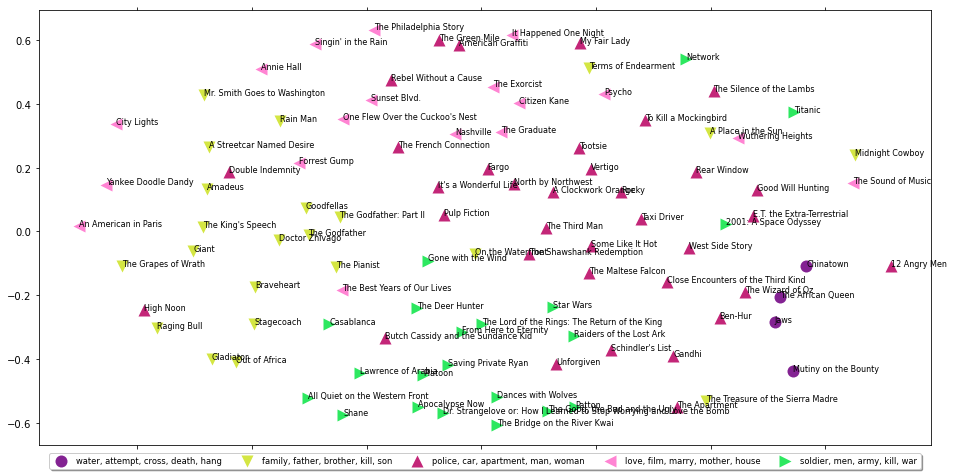

In [14]:
# Now visualize the clusters produced
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))   

In [15]:
# We now repeat the steps of performing clustering using a different algorithm: AP
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [16]:
# Get clusters using affinity propagation (AP)
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

# Get the total number of movies per cluster as before
c = Counter(clusters)   
print(c.items())

dict_items([(0, 5), (2, 12), (5, 9), (11, 4), (1, 6), (16, 8), (3, 7), (13, 7), (7, 4), (8, 9), (12, 5), (10, 2), (4, 5), (6, 7), (14, 4), (15, 3), (9, 3)])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [17]:
# How many clusters are there in total?
total_clusters = len(c)
print('Total Clusters:', total_clusters)

Total Clusters: 17


In [18]:
# Get clustering analysis data using our generic function
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

# Print clustering analysis results
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['able', 'another', 'daughter', 'entire', 'enter']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: ['allow', 'across', 'arrest', 'alive', 'become']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: ['appear', 'finish', 'fire', 'father', 'enough']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: ['arrive', 'finish', 'father', 'fire', 'everyone']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, The Exorcist, Close Encounters of the 

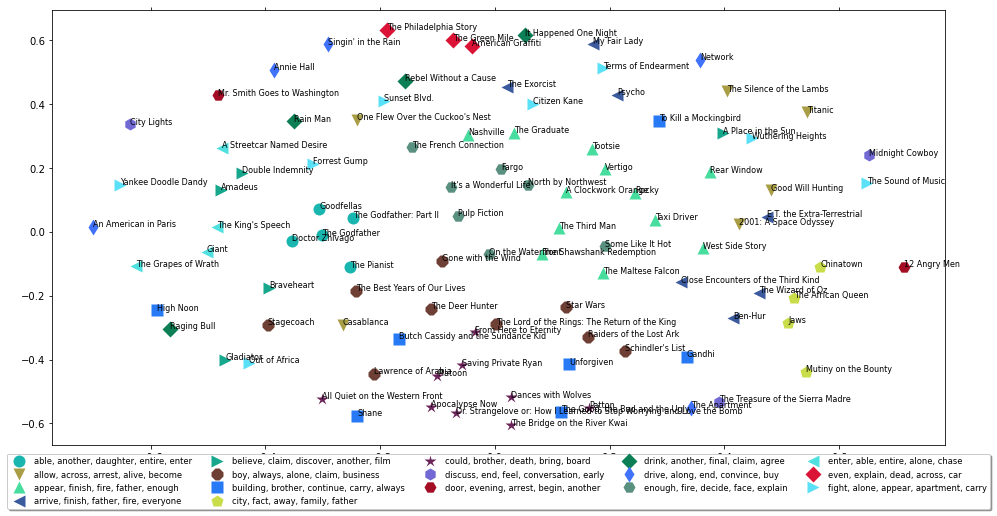

In [19]:
# Visualize the clusters as before using our generic function
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

In [20]:
# We finally repeat the steps of performing clustering again for Hierarchical clustering
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [21]:
# Plotting hierarchical plot objects is different to 'partitioned' (hard) clusters
# since they need to be plotted as a dendrogram and not points on a 2-dim graph
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

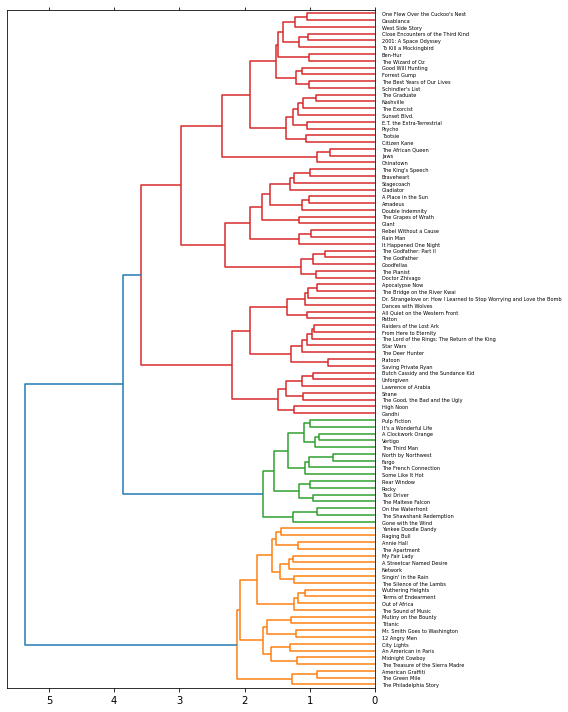

In [22]:
# Build ward's linkage matrix by calling the above function
linkage_matrix = ward_hierarchical_clustering(feature_matrix)

# Plot the clustering output as a dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))